# 3D Event Visualization with Custom Time Surface

This notebook visualizes event camera data in a 3D scatter plot with:
- **X axis**: Spatial x-coordinate
- **Y axis**: Spatial y-coordinate  
- **Time axis**: Timestamp in seconds
- **Custom Time Surface**: Spatially-varying time windows (center retains more history)
- **Interactive controls**: Rotate, zoom, and adjust parameters in real-time

In [1]:
import h5py
import hdf5plugin
import os
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from pathlib import Path
import cv2

os.environ['HDF5_PLUGIN_PATH'] = os.path.dirname(hdf5plugin.__file__)

try:
    import plotly.graph_objects as go
    PLOTLY_AVAILABLE = True
    print("✓ Plotly available")
except ImportError:
    PLOTLY_AVAILABLE = False
    print("✗ Plotly not installed. Run: pip install plotly")

try:
    import ipywidgets as widgets
    from IPython.display import display, clear_output
    WIDGETS_AVAILABLE = True
    print("✓ ipywidgets available")
except ImportError:
    WIDGETS_AVAILABLE = False
    print("✗ ipywidgets not installed. Run: pip install ipywidgets")

print("\nLibraries loaded!")

✓ Plotly available
✓ ipywidgets available

Libraries loaded!


## Custom Time Surface Functions

These functions create spatially-varying time windows where:
- **Center pixels**: Retain maximum time history
- **Border pixels**: Retain minimum time history

This creates a "foveated" temporal attention - focusing detail in the center.

In [2]:
def calculate_pixel_lengths_power(frame_shape, max_length, min_length=None, gamma=2.0):
    """
    Power-law falloff time surface.
    w = (1 - r)^gamma where r is normalized distance from center.
    
    Args:
        frame_shape: (height, width)
        max_length: Maximum time window at center (microseconds)
        min_length: Minimum time window at borders (default: max_length/10)
        gamma: Power exponent (higher = sharper falloff)
    """
    height, width = frame_shape
    if min_length is None:
        min_length = max_length / 10.0

    y, x = np.arange(height), np.arange(width)
    X, Y = np.meshgrid(x, y)
    center_x, center_y = width / 2.0, height / 2.0

    max_distance = np.sqrt((width/2.0)**2 + (height/2.0)**2)
    distance = np.sqrt((X - center_x)**2 + (Y - center_y)**2)
    r = distance / max_distance

    w = np.clip((1.0 - r)**gamma, 0.0, 1.0)
    pixel_lengths = min_length + (max_length - min_length) * w
    return pixel_lengths


def calculate_pixel_lengths_rational(frame_shape, max_length, min_length=None, gamma=2.0, r0=0.45):
    """
    Rational falloff time surface with configurable knee point.
    dt(r) = dt_min + (dt_max - dt_min) / (1 + (r/r0)^gamma)
    
    Args:
        frame_shape: (height, width)
        max_length: Maximum time window at center (microseconds)
        min_length: Minimum time window at borders
        gamma: Power exponent for sharpness
        r0: Normalized radius where drop starts ("knee")
    """
    height, width = frame_shape
    if min_length is None:
        min_length = max_length / 10.0

    y, x = np.arange(height), np.arange(width)
    X, Y = np.meshgrid(x, y)
    center_x, center_y = width / 2.0, height / 2.0

    max_distance = np.sqrt((width/2.0)**2 + (height/2.0)**2)
    distance = np.sqrt((X - center_x)**2 + (Y - center_y)**2)
    r = distance / max_distance

    pixel_lengths = min_length + (max_length - min_length) / (1 + (r/r0)**gamma)
    return pixel_lengths


def apply_time_surface(events, time_surface, frame_shape):
    """
    Apply custom time surface filtering to events.
    Each pixel has its own time threshold - events older than the threshold are removed.
    
    Args:
        events: dict with 'x', 'y', 't', 'p'
        time_surface: 2D array of per-pixel time thresholds (in microseconds)
        frame_shape: (height, width)
    
    Returns:
        Filtered events dict
    """
    if len(events['x']) == 0:
        return events
    
    x = events['x'].astype(int)
    y = events['y'].astype(int)
    t = events['t']
    p = events['p']
    
    height, width = frame_shape
    
    # Filter out-of-bounds
    valid = (x >= 0) & (x < width) & (y >= 0) & (y < height)
    x_valid, y_valid, t_valid, p_valid = x[valid], y[valid], t[valid], p[valid]
    
    if len(t_valid) == 0:
        return {'x': np.array([]), 'y': np.array([]), 't': np.array([]), 'p': np.array([])}
    
    # Get per-pixel time thresholds
    time_thresholds = time_surface[y_valid, x_valid]
    
    # Filter: keep events where (max_time - event_time) < threshold
    max_time = t_valid.max()
    event_age = max_time - t_valid
    keep_mask = event_age < time_thresholds
    
    return {
        'x': x_valid[keep_mask],
        'y': y_valid[keep_mask],
        't': t_valid[keep_mask],
        'p': p_valid[keep_mask]
    }

print("Time surface functions loaded!")

Time surface functions loaded!


## Inspect Events File

In [3]:
EVENT_FILE = Path("events.h5")

with h5py.File(str(EVENT_FILE), 'r') as f:
    t_offset = int(f['t_offset'][()]) if 't_offset' in f.keys() else 0
    t_raw = np.asarray(f['events/t'], dtype=np.int64)
    x_sample = np.asarray(f['events/x'][:1000])
    y_sample = np.asarray(f['events/y'][:1000])
    
    print(f"Total events: {len(t_raw):,}")
    print(f"Raw time range: {t_raw[0]/1e6:.4f}s to {t_raw[-1]/1e6:.4f}s")
    print(f"Duration: {(t_raw[-1] - t_raw[0])/1e6:.4f}s")
    print(f"Sensor resolution: ~{x_sample.max()+1} x {y_sample.max()+1}")

Total events: 152,299,794
Raw time range: 0.0000s to 18.9010s
Duration: 18.9010s
Sensor resolution: ~640 x 477


## Configuration

In [4]:
# File paths
RGB_VIDEO = Path("rgb_calibrated.mp4")

# Time window (use raw timestamps from above)
T_START_SEC = 0.0
T_END_SEC = 0.05  # Start small (100ms window)

# Visualization
SUBSAMPLE_FACTOR = 10
NUM_FRAME_OVERLAYS = 3
USE_ABSOLUTE_TIMESTAMPS = False

# Frame shape (height, width) - adjust if needed
FRAME_SHAPE = (480, 640)

# Time surface parameters
TIME_SURFACE_MODE = 'rational'  # 'power', 'rational', or 'none'
HIGH_LOW_RATIO = 10.0  # max_time / min_time ratio
GAMMA = 2.0  # Power exponent (higher = sharper falloff at edges)
R0 = 0.3  # Knee point for rational mode

## Load Events

In [5]:
def load_events_from_h5(filepath, t_start_sec=None, t_end_sec=None, use_absolute=False):
    with h5py.File(str(filepath), 'r') as f:
        t_offset = int(f['t_offset'][()]) if 't_offset' in f.keys() else 0
        x = np.asarray(f['events/x'])
        y = np.asarray(f['events/y'])
        t_raw = np.asarray(f['events/t'], dtype=np.int64)
        p = np.asarray(f['events/p'])
        
        t = t_raw + t_offset if use_absolute else t_raw
        
        if t_start_sec is not None or t_end_sec is not None:
            t_start_us = int(t_start_sec * 1e6) if t_start_sec is not None else t[0]
            t_end_us = int(t_end_sec * 1e6) if t_end_sec is not None else t[-1]
            mask = (t >= t_start_us) & (t <= t_end_us)
            x, y, t, p = x[mask], y[mask], t[mask], p[mask]
            
        print(f"Loaded {len(x):,} events ({t_start_sec:.3f}s to {t_end_sec:.3f}s)")
        if len(x) == 0:
            print("⚠️ No events in time window!")
    return {'x': x, 'y': y, 't': t, 'p': p}

events_raw = load_events_from_h5(EVENT_FILE, T_START_SEC, T_END_SEC, USE_ABSOLUTE_TIMESTAMPS)

Loaded 438,022 events (0.000s to 0.050s)


## Create and Visualize Time Surface

Window duration: 50.0 ms
Center time threshold: 50.0 ms
Border time threshold: 5.0 ms

Using RATIONAL mode (gamma=2.0, r0=0.3)


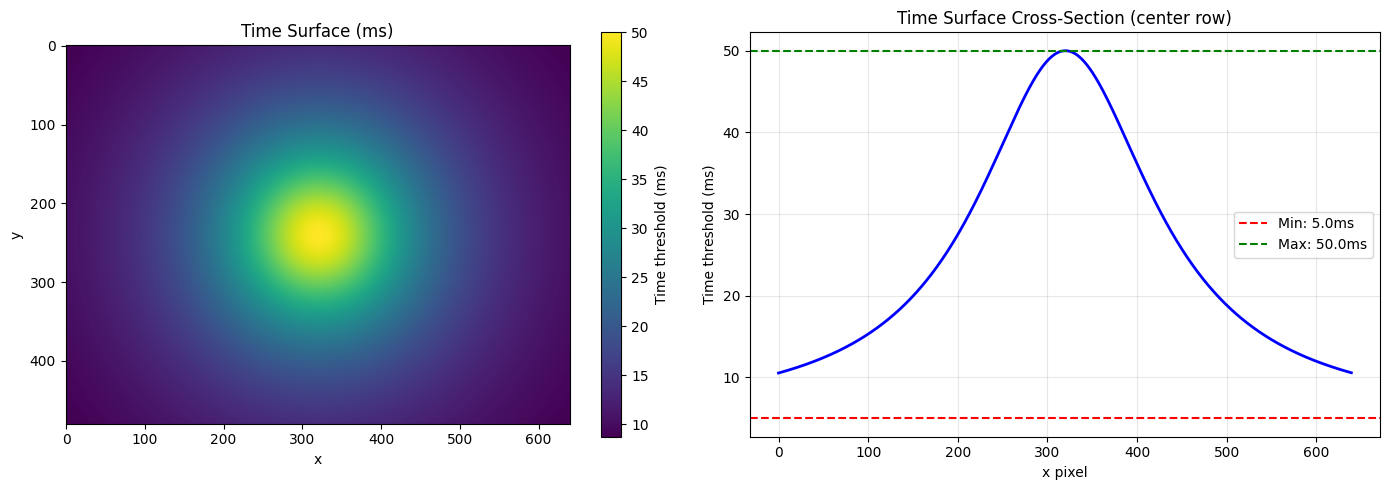

In [6]:
# Calculate the time window duration
window_duration_us = (T_END_SEC - T_START_SEC) * 1e6
max_time_us = window_duration_us
min_time_us = max_time_us / HIGH_LOW_RATIO

print(f"Window duration: {window_duration_us/1000:.1f} ms")
print(f"Center time threshold: {max_time_us/1000:.1f} ms")
print(f"Border time threshold: {min_time_us/1000:.1f} ms")

# Create time surface
if TIME_SURFACE_MODE == 'power':
    time_surface = calculate_pixel_lengths_power(FRAME_SHAPE, max_time_us, min_time_us, GAMMA)
    print(f"\nUsing POWER mode (gamma={GAMMA})")
elif TIME_SURFACE_MODE == 'rational':
    time_surface = calculate_pixel_lengths_rational(FRAME_SHAPE, max_time_us, min_time_us, GAMMA, R0)
    print(f"\nUsing RATIONAL mode (gamma={GAMMA}, r0={R0})")
else:
    time_surface = None
    print("\nTime surface DISABLED")

# Visualize the time surface
if time_surface is not None:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # 2D heatmap
    im = axes[0].imshow(time_surface/1000, cmap='viridis')
    axes[0].set_title('Time Surface (ms)')
    axes[0].set_xlabel('x')
    axes[0].set_ylabel('y')
    plt.colorbar(im, ax=axes[0], label='Time threshold (ms)')
    
    # Cross-section through center
    center_row = FRAME_SHAPE[0] // 2
    axes[1].plot(time_surface[center_row, :] / 1000, 'b-', linewidth=2)
    axes[1].set_title('Time Surface Cross-Section (center row)')
    axes[1].set_xlabel('x pixel')
    axes[1].set_ylabel('Time threshold (ms)')
    axes[1].grid(True, alpha=0.3)
    axes[1].axhline(y=min_time_us/1000, color='r', linestyle='--', label=f'Min: {min_time_us/1000:.1f}ms')
    axes[1].axhline(y=max_time_us/1000, color='g', linestyle='--', label=f'Max: {max_time_us/1000:.1f}ms')
    axes[1].legend()
    
    plt.tight_layout()
    plt.show()

## Apply Time Surface Filter

In [7]:
# Apply time surface filtering
if time_surface is not None and len(events_raw['x']) > 0:
    events = apply_time_surface(events_raw, time_surface, FRAME_SHAPE)
    print(f"Before filtering: {len(events_raw['x']):,} events")
    print(f"After filtering:  {len(events['x']):,} events")
    print(f"Removed: {len(events_raw['x']) - len(events['x']):,} events ({100*(1-len(events['x'])/len(events_raw['x'])):.1f}%)")
else:
    events = events_raw
    print("No time surface filtering applied")

Before filtering: 438,022 events
After filtering:  140,645 events
Removed: 297,377 events (67.9%)


## Load RGB Frames (Optional)

In [8]:
def get_rgb_frames_at_timestamps(video_path, timestamps_sec, video_fps=20):
    if not video_path.exists():
        return []
    cap = cv2.VideoCapture(str(video_path))
    frames = []
    for ts in timestamps_sec:
        cap.set(cv2.CAP_PROP_POS_FRAMES, int(ts * video_fps))
        ret, frame = cap.read()
        if ret:
            frames.append((ts, cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)))
    cap.release()
    return frames

rgb_frames = []
if NUM_FRAME_OVERLAYS > 0 and RGB_VIDEO.exists() and len(events['x']) > 0:
    frame_timestamps = np.linspace(T_START_SEC, T_END_SEC, NUM_FRAME_OVERLAYS + 2)[1:-1]
    rgb_frames = get_rgb_frames_at_timestamps(RGB_VIDEO, frame_timestamps)
    print(f"Loaded {len(rgb_frames)} RGB frames")

---
# 🎮 Interactive 3D Visualization

**Mouse Controls:**
- **Left-click + drag**: Rotate view
- **Right-click + drag**: Pan
- **Scroll**: Zoom in/out
- **Double-click**: Reset view

In [9]:

def create_interactive_3d(events, events_raw=None, subsample=1, rgb_frames=None, 
                          point_size=1.5, color_by_polarity=False, show_frames=True,
                          frame_mode='Last', show_filtered_comparison=False):
    if not PLOTLY_AVAILABLE:
        print("Plotly required! Install with: pip install plotly")
        return None
    
    if len(events['x']) == 0:
        print("No events to plot!")
        return None
    
    data = []
    
    # Raw events
    if show_filtered_comparison and events_raw is not None and len(events_raw['x']) > 0:
        x_raw = events_raw['x'][::subsample*3]
        y_raw = events_raw['y'][::subsample*3]
        t_raw = events_raw['t'][::subsample*3] / 1e6
        data.append(go.Scatter3d(
            x=t_raw, y=x_raw, z=y_raw,
            mode='markers',
            marker=dict(size=0.8, color='lightgray', opacity=0.2),
            name='Raw events'
        ))
    
    # Main events
    x = events['x'][::subsample]
    y = events['y'][::subsample]
    t = events['t'][::subsample] / 1e6
    p = events['p'][::subsample]
    
    print(f"Plotting {len(x):,} events")
    
    if color_by_polarity:
        pos_mask = p == 1
        data.append(go.Scatter3d(
            x=t[pos_mask], y=x[pos_mask], z=y[pos_mask],
            mode='markers',
            marker=dict(size=point_size, color='blue', opacity=0.6),
            name='ON events'
        ))
        neg_mask = ~pos_mask
        data.append(go.Scatter3d(
            x=t[neg_mask], y=x[neg_mask], z=y[neg_mask],
            mode='markers',
            marker=dict(size=point_size, color='red', opacity=0.6),
            name='OFF events'
        ))
    else:
        data.append(go.Scatter3d(
            x=t, y=x, z=y,
            mode='markers',
            marker=dict(size=point_size, color='dodgerblue', opacity=0.6),
            name='Filtered events'
        ))
    
    # RGB Frames
    if show_frames and rgb_frames:
        frames_to_show = []
        
        # Calculate MAX time for positioning 'End'
        time_pos = events['t'].max() / 1e6
        
        if frame_mode == 'Last':
            # Use last frame content, position at END
            frames_to_show = [(time_pos, rgb_frames[-1][1])] 
        elif frame_mode == '3 Frames':
            if len(rgb_frames) <= 3:
                frames_to_show = rgb_frames
            else:
                indices = np.linspace(0, len(rgb_frames) - 1, 3, dtype=int)
                frames_to_show = [rgb_frames[i] for i in indices]
        elif frame_mode == 'All':
            frames_to_show = rgb_frames
        
        if frames_to_show:
            x_max, y_max = 640, 480 
            
            for ts, frame in frames_to_show:
                frame_resized = cv2.resize(frame, (x_max, y_max))
                
                # Apply Horizontal Flip (1) to fix "mirrored"
                frame_resized = cv2.flip(frame_resized, 1)
                
                frame_gray = cv2.cvtColor(frame_resized, cv2.COLOR_RGB2GRAY) if len(frame_resized.shape) == 3 else frame_resized
                xx, yy = np.arange(frame_gray.shape[1]), np.arange(frame_gray.shape[0])
                
                # If Single Last, use overridden time_pos
                t_val = ts if frame_mode != 'Last' else time_pos

                data.append(go.Surface(
                    x=np.full_like(frame_gray, t_val, dtype=float),
                    y=np.tile(xx, (len(yy), 1)), 
                    z=np.tile(yy.reshape(-1, 1), (1, len(xx))), 
                    surfacecolor=frame_gray,
                    colorscale='gray',
                    showscale=False,
                    opacity=0.8,
                    name=f'Frame'
                ))
    
    fig = go.Figure(data=data)
    fig.update_layout(
        title='3D Event Visualization',
        scene=dict(
            xaxis_title='Time [s]',
            yaxis_title='x',
            zaxis_title='y',
            zaxis=dict(autorange='reversed'),
            aspectmode='manual',
            aspectratio=dict(x=2, y=1, z=0.75),
            camera=dict(eye=dict(x=1.5, y=1.5, z=0.5))
        ),
        width=1000, height=700, showlegend=True,
    )
    return fig


## 🎛️ Interactive Widget Controls

Adjust time surface and visualization parameters in real-time.

In [10]:

def create_interactive_2d(events, events_raw=None, subsample=1, rgb_frames=None, 
                          point_size=1.5, color_by_polarity=False, show_frames=True,
                          frame_mode='Last', show_filtered_comparison=False):
    if not PLOTLY_AVAILABLE: return None
    if len(events['x']) == 0: return None
        
    data = []
    
    # 1. Overlay Image
    if show_frames and rgb_frames:
        target_frame = None
        if frame_mode == 'Last' and len(rgb_frames) > 0:
            target_frame = rgb_frames[-1][1]
        elif (frame_mode == '3 Frames' or frame_mode == 'All') and len(rgb_frames) > 0:
            target_frame = rgb_frames[-1][1]
            
        if target_frame is not None:
            # Force 640x480
            if target_frame.shape[1] != 640 or target_frame.shape[0] != 480:
                target_frame = cv2.resize(target_frame, (640, 480))
            
            # Flip vertical for 2D as well to match 3D if requested? 
            # Usually 2D plots are standard image coords (y down). 
            # If 3D is flipped because of reversed axis, 2D might be fine.
            # I will leave 2D unflipped unless requested, assuming the "falpped" issue is specific to 3D surface mapping.
            
            if len(target_frame.shape) == 3:
                data.append(go.Image(z=target_frame, name="RGB Frame", opacity=0.7, hoverinfo='skip'))
            else:
                 data.append(go.Image(z=target_frame, name="Greyscale Frame", colormodel='gray', opacity=0.7, hoverinfo='skip'))

    # 2. Raw events
    if show_filtered_comparison and events_raw is not None and len(events_raw['x']) > 0:
        x_raw = events_raw['x'][::subsample*3]
        y_raw = events_raw['y'][::subsample*3]
        data.append(go.Scatter(
            x=x_raw, y=y_raw,
            mode='markers',
            marker=dict(size=0.8, color='lightgray', opacity=0.2),
            name='Raw (filtered)',
            showlegend=True
        ))
        
    # 3. Main events
    x = events['x'][::subsample]
    y = events['y'][::subsample]
    p = events['p'][::subsample]
    
    if color_by_polarity:
        pos_mask = p == 1
        data.append(go.Scatter(
            x=x[pos_mask], y=y[pos_mask],
            mode='markers',
            marker=dict(size=point_size, color='blue', opacity=0.6),
            name='ON'
        ))
        neg_mask = ~pos_mask
        data.append(go.Scatter(
            x=x[neg_mask], y=y[neg_mask],
            mode='markers',
            marker=dict(size=point_size, color='red', opacity=0.6),
            name='OFF'
        ))
    else:
        data.append(go.Scatter(
            x=x, y=y,
            mode='markers',
            marker=dict(size=point_size, color='dodgerblue', opacity=0.6),
            name='Events'
        ))
             
    fig = go.Figure(data=data)
    fig.update_layout(
        title='2D Event Visualization',
        xaxis_title='x',
        yaxis_title='y',
        yaxis=dict(autorange='reversed'),
        width=800, height=600,
        showlegend=True
    )
    return fig


In [11]:

if WIDGETS_AVAILABLE and PLOTLY_AVAILABLE and len(events_raw['x']) > 0:
    # Visualization controls
    subsample_slider = widgets.IntSlider(value=10, min=1, max=100, step=1, description='Subsample:')
    point_size_slider = widgets.FloatSlider(value=1.5, min=0.5, max=5.0, step=0.5, description='Point Size:')
    polarity_checkbox = widgets.Checkbox(value=False, description='Color by Polarity')
    comparison_checkbox = widgets.Checkbox(value=True, description='Compare Raw')
    
    # Frame controls
    frame_mode_dropdown = widgets.Dropdown(options=['Last', '3 Frames', 'All', 'None'], value='Last', description='Frame Mode:')
    frames_2d_checkbox = widgets.Checkbox(value=True, description='Show Frames (2D)')
    frames_3d_checkbox = widgets.Checkbox(value=True, description='Show Frames (3D)')
    
    # Time surface controls
    mode_dropdown = widgets.Dropdown(options=['power', 'rational', 'none'], value=TIME_SURFACE_MODE, description='TS Mode:')
    gamma_slider = widgets.FloatSlider(value=GAMMA, min=0.5, max=5.0, step=0.1, description='Gamma:')
    ratio_slider = widgets.FloatSlider(value=HIGH_LOW_RATIO, min=2.0, max=50.0, step=1.0, description='Hi/Lo Ratio:')
    r0_slider = widgets.FloatSlider(value=R0, min=0.1, max=0.9, step=0.05, description='r0 (rational):')
    
    output_3d = widgets.Output()
    output_2d = widgets.Output()
    
    def update_plot(change=None):
        max_t = (T_END_SEC - T_START_SEC) * 1e6
        min_t = max_t / ratio_slider.value
        
        ts = None
        if mode_dropdown.value == 'power':
            ts = calculate_pixel_lengths_power(FRAME_SHAPE, max_t, min_t, gamma_slider.value)
        elif mode_dropdown.value == 'rational':
            ts = calculate_pixel_lengths_rational(FRAME_SHAPE, max_t, min_t, gamma_slider.value, r0_slider.value)
        
        if ts is not None:
            filtered = apply_time_surface(events_raw, ts, FRAME_SHAPE)
        else:
            filtered = events_raw
        
        with output_3d:
            output_3d.clear_output(wait=True)
            print(f"3D: {len(filtered['x']):,} events")
            fig = create_interactive_3d(
                filtered, events_raw if comparison_checkbox.value else None,
                subsample=subsample_slider.value,
                rgb_frames=rgb_frames,
                point_size=point_size_slider.value,
                color_by_polarity=polarity_checkbox.value,
                show_frames=frames_3d_checkbox.value,
                frame_mode=frame_mode_dropdown.value,
                show_filtered_comparison=comparison_checkbox.value
            )
            if fig: fig.show()

        with output_2d:
            output_2d.clear_output(wait=True)
            print(f"2D: {len(filtered['x']):,} events")
            fig2 = create_interactive_2d(
                filtered, events_raw if comparison_checkbox.value else None,
                subsample=subsample_slider.value,
                rgb_frames=rgb_frames,
                point_size=point_size_slider.value,
                color_by_polarity=polarity_checkbox.value,
                show_frames=frames_2d_checkbox.value,
                frame_mode=frame_mode_dropdown.value,
                show_filtered_comparison=comparison_checkbox.value
            )
            if fig2: fig2.show()
    
    for w in [subsample_slider, point_size_slider, polarity_checkbox, comparison_checkbox,
              frame_mode_dropdown, frames_2d_checkbox, frames_3d_checkbox,
              mode_dropdown, gamma_slider, ratio_slider, r0_slider]:
        w.observe(update_plot, names='value')
    
    vis_controls = widgets.VBox([subsample_slider, point_size_slider, polarity_checkbox, comparison_checkbox])
    frame_controls = widgets.VBox([frame_mode_dropdown, frames_2d_checkbox, frames_3d_checkbox])
    ts_controls = widgets.VBox([mode_dropdown, gamma_slider, ratio_slider, r0_slider])
    
    controls = widgets.HBox([
        widgets.VBox([widgets.HTML('<b>Vis</b>'), vis_controls]),
        widgets.VBox([widgets.HTML('<b>Frames</b>'), frame_controls]),
        widgets.VBox([widgets.HTML('<b>Time Surface</b>'), ts_controls])
    ])
    
    tabs = widgets.Tab(children=[output_3d, output_2d])
    tabs.set_title(0, '3D View')
    tabs.set_title(1, '2D View')
    
    display(controls)
    display(tabs)
    update_plot()
else:
    print("Install plotly and ipywidgets for interactive controls")


## 📊 Static Comparison View

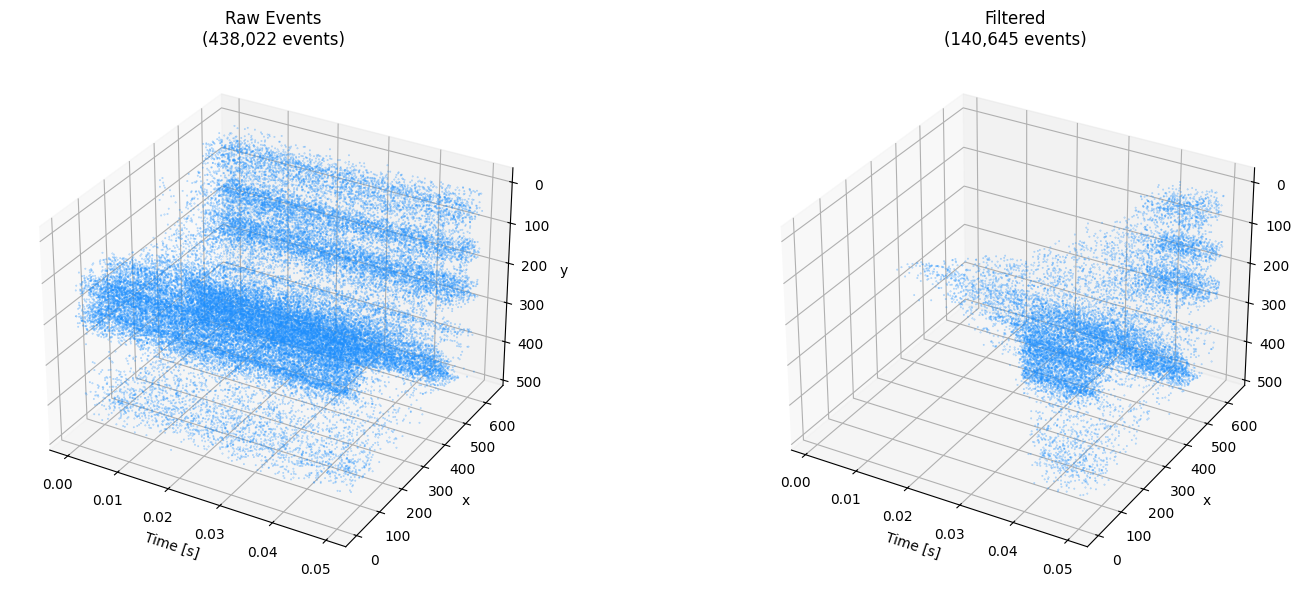

In [12]:
def plot_comparison_static(events_raw, events_filtered, subsample=10, figsize=(16, 6)):
    """Side-by-side comparison of raw vs filtered events."""
    if len(events_raw['x']) == 0:
        print("No events!")
        return
    
    fig, axes = plt.subplots(1, 2, figsize=figsize, subplot_kw={'projection': '3d'})
    
    for ax, ev, title in [(axes[0], events_raw, 'Raw Events'), 
                          (axes[1], events_filtered, 'Filtered')]:
        if len(ev['x']) == 0:
            ax.set_title(f"{title} (no events)")
            continue
            
        x = ev['x'][::subsample]
        y = ev['y'][::subsample]
        t = ev['t'][::subsample] / 1e6
        
        ax.scatter(t, x, y, c='dodgerblue', s=0.1, alpha=0.5)
        ax.set_xlabel('Time [s]')
        ax.set_ylabel('x')
        ax.set_zlabel('y')
        ax.invert_zaxis()
        ax.set_title(f"{title}\n({len(ev['x']):,} events)")
    
    plt.tight_layout()
    plt.show()

if len(events_raw['x']) > 0:
    plot_comparison_static(events_raw, events, subsample=SUBSAMPLE_FACTOR)